In [30]:
import pandas as pd
from typing import TypedDict, Dict, Any
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from langchain_community.document_loaders import PyPDFLoader
import os
from dotenv import load_dotenv
load_dotenv()

True

In [31]:
# Load the small demo claims CSV (3 rows only)
claims_df = pd.read_csv("data/warranty_claims.csv")

# Load the expanded policy manual PDF
loader = PyPDFLoader("data/AutoDrive_Warranty_Policy_2025.pdf")
policy_docs = loader.load()
policy_text = " ".join([doc.page_content for doc in policy_docs])

In [32]:
claims_df

,claim_id,model,purchase_date,claim_date,days_since_purchase,mileage,part_replaced,part_cost,labor_cost,total_cost,invoice_present,image_present,previous_claims
0,CLM-DEMO-1,"Volt-X (Four-Wheeler, EV Sedan)",8/8/2024,5/24/2025,289,7363,Headlight,231,199,430,1,1,1


In [33]:
policy_text

'AutoDrive Motors Pvt. Ltd.\nWarranty Claims Policy Manual\nEffective Date: January 1, 2025\nVersion: 1.2\n1. Documentation Requirements\n- Every warranty claim must include:\n- A valid invoice copy with purchase date, VIN, and customer ID.\n- At least one supporting image (part photo, repair slip).\n- Service center job card when applicable.\n- Claims without documentation must be escalated for manual review.\n2. Warranty Coverage\n- Four-Wheelers: 365 days OR 20,000 km (whichever comes first).\n- Two-Wheelers: 180 days OR 10,000 km (whichever comes first).\n- Only claims for original manufacturer parts are considered valid.\n3. Covered Parts\n- Four-Wheelers: Brake Pad, Airbag, Fuel Pump, Battery, Sensor, ECU, Alternator.\n- Two-Wheelers: Brake Pad, Battery, Sensor, Headlight, Starter Motor.\nExclusions:\n- Paint, upholstery, glass, wipers, and other wear-and-tear items.\n- Accidental damage or unauthorized modifications.\n4. Labor & Cost Guidelines\n- Labor cost per claim should not

In [34]:
llm = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model="llama-3.1-8b-instant",
    temperature=0
)

In [35]:
class ClaimState(TypedDict):
    claim: Dict[str, Any]
    policy_check: str
    fraud_score: float
    evidence: str
    decision: str

In [36]:
# 1. Policy Check Agent (structured validation via PDF rules)
def policy_check_agent(state: ClaimState) -> ClaimState:
    claim = state["claim"]
    vtype = "Four-Wheeler" if "Four-Wheeler" in claim["model"] else "Two-Wheeler"
    
    prompt = f"""
    You are a warranty compliance officer. 
    Policy manual:
    {policy_text}
    
    Vehicle type: {vtype}
    Claim details: {claim}
    
    Based on warranty days, mileage, and covered parts,
    is this claim covered under the policy? 
    Answer with: "Covered by policy" or "Not covered by policy".
    """
    
    response = llm.invoke(prompt)
    state["policy_check"] = response.content.strip()
    return state


# 2. Fraud Scoring Agent
def fraud_scoring_agent(state: ClaimState) -> ClaimState:
    claim = state["claim"]
    prompt = f"""
    You are a fraud detection expert.
    Policy manual:
    {policy_text}
    
    Claim details:
    {claim}
    Policy validation: {state['policy_check']}
    
    Analyze whether this claim looks fraudulent.
    Return ONLY a number between 0 and 1 (fraud likelihood score).
    """
    response = llm.invoke(prompt)
    try:
        score = float(response.content.strip())
    except:
        score = 0.5
    state["fraud_score"] = score
    return state



# 3. Evidence Collector Agent
def evidence_collector_agent(state: ClaimState) -> ClaimState:
    claim = state["claim"]
    prompt = f"""
    You are tasked with collecting evidence for claim review.
    Policy manual:
    {policy_text}
    
    Claim details:
    {claim}
    Fraud score: {state['fraud_score']}
    
    Compare claim against the policy manual and fraud indicators.
    List any red flags or violations found. If none, say "No issues".
    """
    response = llm.invoke(prompt)
    state["evidence"] = response.content.strip()
    return state


def action_agent(state: ClaimState) -> ClaimState:
    # Prefer an LLM-informed final decision that considers previous agents' outputs.
    # Build a compact prompt summarizing the claim and previous agent outputs.
    claim = state.get("claim", {})
    policy_check = state.get("policy_check", "")
    fraud_score = state.get("fraud_score", 0.0)
    evidence = state.get("evidence", "")

    prompt = f"""
    You are a warranty adjudicator. Given the following information about a warranty claim, choose one of three actions: "Approve claim", "Reject claim", or "Escalate to HITL" (human-in-the-loop for manual review).

    Provide your answer as a single decision on the first line, and then a short (1-2 sentence) justification on the following line.

    Policy manual (for reference):
    {policy_text}

    Claim details: {claim}

    Policy check result: {policy_check}
    Fraud score (0-1): {fraud_score}
    Evidence / red flags found: {evidence}

    Important: If the policy_check indicates the claim is "Not covered by policy" or the evidence highlights a direct policy violation (e.g., part not covered), prefer "Reject claim" unless strong justification exists to approve. If the evidence is ambiguous, but fraud score is moderately high (>0.5), choose "Escalate to HITL".
    """

    decision_text = ""
    try:
        response = llm.invoke(prompt)
        res_text = response.content.strip()
        # Try to parse the first line as the decision
        first_line = res_text.splitlines()[0].strip()
        normalized = first_line.lower()
        if "approve" in normalized:
            decision_text = "Approve claim"
        elif "reject" in normalized:
            decision_text = "Reject claim"
        elif "escalate" in normalized or "hitl" in normalized or "human" in normalized:
            decision_text = "Escalate to HITL"
        else:
            # If parsing fails, fall back to rule-based decision
            decision_text = ""

        # Record the full LLM response in the trace
        state.setdefault("trace", []).append({
            "agent": "action_agent",
            "prompt": prompt,
            "response": res_text,
        })
    except Exception:
        # LLM failed — leave res_text empty and fall back
        res_text = ""

    # If LLM didn't produce a clear decision, use conservative rule-based fallback
    if not decision_text:
        if policy_check == "Not covered by policy":
            decision_text = "Reject claim"
        elif fraud_score > 0.5:
            decision_text = "Escalate to HITL"
        else:
            decision_text = "Approve claim"

        # record fallback decision step in trace (clear about being rule-based)
        state.setdefault("trace", []).append({
            "agent": "action_agent",
            "prompt": "(rule-based fallback)",
            "response": decision_text,
        })

    state["decision"] = decision_text
    return state

In [37]:
graph = StateGraph(ClaimState)

graph.add_node("PolicyCheck", policy_check_agent)
graph.add_node("FraudScoring", fraud_scoring_agent)
graph.add_node("EvidenceCollector", evidence_collector_agent)
graph.add_node("Action", action_agent)

graph.set_entry_point("PolicyCheck")
graph.add_edge("PolicyCheck", "FraudScoring")
graph.add_edge("FraudScoring", "EvidenceCollector")
graph.add_edge("EvidenceCollector", "Action")
graph.add_edge("Action", END)

app = graph.compile()

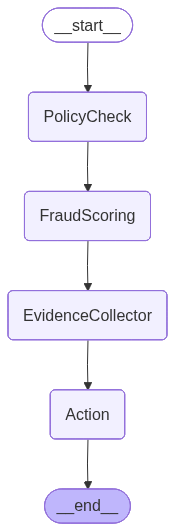

In [42]:
from IPython.display import display, Markdown, Image

# Get the Mermaid code
mermaid_code = app.get_graph().draw_mermaid_png()

# Display in Jupyter
display(Image(data=mermaid_code))

In [39]:
results = []

for idx, row in claims_df.iterrows():
    state = app.invoke({"claim": row.to_dict()})
    results.append({
        "claim_id": row["claim_id"],
        "model": row["model"],
        "decision": state["decision"],
        "policy_check": state["policy_check"],
        "fraud_score": state["fraud_score"],
        "evidence": state["evidence"]
    })

results_df = pd.DataFrame(results)

In [40]:
results_df

,claim_id,model,decision,policy_check,fraud_score,evidence
0,CLM-DEMO-1,"Volt-X (Four-Wheeler, EV Sedan)",Reject claim,"Based on the provided information, the claim i...",0.5,Based on the provided claim details and policy...


In [41]:
state

{'claim': {'claim_id': 'CLM-DEMO-1',
  'model': 'Volt-X (Four-Wheeler, EV Sedan)',
  'purchase_date': '8/8/2024',
  'claim_date': '5/24/2025',
  'days_since_purchase': 289,
  'mileage': 7363,
  'part_replaced': 'Headlight',
  'part_cost': 231,
  'labor_cost': 199,
  'total_cost': 430,
  'invoice_present': 1,
  'image_present': 1,
  'previous_claims': 1},
 'policy_check': "Based on the provided information, the claim is Not covered by policy. \n\nThe reason is that the part replaced, 'Headlight', is not a covered part for Four-Wheelers as per the policy manual (Section 3: Covered Parts).",
 'fraud_score': 0.5,
 'evidence': "Based on the provided claim details and policy manual, the following red flags or violations are found:\n\n1. **Exceeds warranty coverage**: The claim is for a Four-Wheeler, and the warranty coverage is 365 days or 20,000 km (whichever comes first). The claim was made on day 289, which is within the warranty period. However, the mileage is 7363, which exceeds the 20,